# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from tqdm import tqdm

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
# env = UnityEnvironment(file_name="Banana.app")
env = UnityEnvironment(file_name="Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [5]:
import torch
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device(type='cuda', index=0)

In [56]:
# create an agent
from dqn_agent import Agent

agent = Agent(
    state_size=state_size, 
    action_size=action_size, 
    update_every_steps=10, 
    lr=1e-3, 
    batch_size=64, 
    memory_size=int(1e5))

Creating network 'local' with 37 input neurons, 4 output, and hidden of 56 and 6
Creating network 'target' with 37 input neurons, 4 output, and hidden of 56 and 6


In [48]:
print(agent.qnetwork_local)
print(agent.version)

QNetwork(
  (fc1): Linear(in_features=37, out_features=56, bias=True)
  (fc2): Linear(in_features=56, out_features=6, bias=True)
  (output): Linear(in_features=6, out_features=4, bias=True)
)
v_debug: use of 'target' when calculating targets


In [46]:
agent.memory.memory

deque([])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


In [9]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2



In [10]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [17]:
def dqn(
    agent,
    n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
    feedback_every_secs=30, keep_last_scores=100,
    file_name_where_to_save='checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        agent (Agent): the agent that takes decisions
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        feedback_every_secs (int): how often (in secs.) do you want to have feedback about the scores.
        keep_last_scores (int): I will keep this many scores and then report on their statistics.
    """
    all_scores = []  # ALL scores
    scores_window = deque(maxlen=keep_last_scores)  # last <keep_last_scores> scores
    eps = eps_start                    # initialize epsilon
    last_time = time.time()
    for i_episode in tqdm(range(1, n_episodes+1)):
        # print("Resetting the episode...\n")
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        # print("... environment reset!\n")
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state=state, eps=eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            agent.step(state=state, action=action, reward=reward, next_state=next_state, done=done)
            state = next_state                             # roll over the state to next time step
            if done:
                # print("===> Environment finished this episode after %d steps (max = %d) (ie, 'done' == True)" % (t, max_t))
                break 
        scores_window.append(score)       # save most recent score
        all_scores.append(score)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if time.time() - last_time >= feedback_every_secs:
            print('\rEpisode {}, eps: {:.3f}\tAverage Score (last {} episodes): {:.2f}'.format(i_episode, eps, keep_last_scores, np.mean(scores_window)))
            last_time = time.time()
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
    print('\rEpisode {}, eps: {:.3f}\tAverage Score (last {} episodes): {:.2f}'.format(i_episode, eps, keep_last_scores, np.mean(scores_window)))
    print("\n Saving best network on '%s'" % (file_name_where_to_save))
    torch.save(agent.qnetwork_local.state_dict(), file_name_where_to_save)
    return all_scores

In [60]:
# agent.set_models_from(torch_file_name='checkpoint.pth')
prob_not_random_at_start_default=(1-0.995) # /15
scores = dqn(
    agent, 
    n_episodes=1387, 
    feedback_every_secs=35, 
    keep_last_scores=100, 
    eps_decay=1 - prob_not_random_at_start_default)

  4%|▍         | 54/1387 [00:35<14:41,  1.51it/s]

Episode 54, eps: 0.763	Average Score (last 100 episodes): 0.52


  8%|▊         | 106/1387 [01:10<14:35,  1.46it/s]

Episode 106, eps: 0.588	Average Score (last 100 episodes): 1.60


 11%|█▏        | 157/1387 [01:45<14:18,  1.43it/s]

Episode 157, eps: 0.455	Average Score (last 100 episodes): 3.62


 15%|█▍        | 207/1387 [02:20<13:53,  1.42it/s]

Episode 207, eps: 0.354	Average Score (last 100 episodes): 4.92


 19%|█▊        | 257/1387 [02:55<13:21,  1.41it/s]

Episode 257, eps: 0.276	Average Score (last 100 episodes): 6.23


 22%|██▏       | 306/1387 [03:31<13:00,  1.38it/s]

Episode 306, eps: 0.216	Average Score (last 100 episodes): 7.37


 26%|██▌       | 355/1387 [04:06<12:26,  1.38it/s]

Episode 355, eps: 0.169	Average Score (last 100 episodes): 7.73


 29%|██▉       | 404/1387 [04:42<11:53,  1.38it/s]

Episode 404, eps: 0.132	Average Score (last 100 episodes): 8.21


 33%|███▎      | 452/1387 [05:17<11:29,  1.36it/s]

Episode 452, eps: 0.104	Average Score (last 100 episodes): 9.05


 36%|███▌      | 500/1387 [05:52<10:56,  1.35it/s]

Episode 500, eps: 0.082	Average Score (last 100 episodes): 10.17


 40%|███▉      | 548/1387 [06:27<10:21,  1.35it/s]

Episode 548, eps: 0.064	Average Score (last 100 episodes): 11.02


 43%|████▎     | 596/1387 [07:03<09:41,  1.36it/s]

Episode 596, eps: 0.050	Average Score (last 100 episodes): 11.35


 46%|████▋     | 644/1387 [07:39<09:10,  1.35it/s]

Episode 644, eps: 0.040	Average Score (last 100 episodes): 11.06


 50%|████▉     | 692/1387 [08:14<08:35,  1.35it/s]

Episode 692, eps: 0.031	Average Score (last 100 episodes): 10.28


 53%|█████▎    | 740/1387 [08:50<08:01,  1.34it/s]

Episode 740, eps: 0.024	Average Score (last 100 episodes): 11.07


 57%|█████▋    | 787/1387 [09:25<07:35,  1.32it/s]

Episode 787, eps: 0.019	Average Score (last 100 episodes): 12.04


 60%|██████    | 834/1387 [10:01<06:58,  1.32it/s]

Episode 834, eps: 0.015	Average Score (last 100 episodes): 12.33


 64%|██████▎   | 881/1387 [10:36<06:22,  1.32it/s]

Episode 881, eps: 0.012	Average Score (last 100 episodes): 12.55


 65%|██████▍   | 895/1387 [10:47<06:14,  1.31it/s]


Environment solved in 796 episodes!	Average Score: 13.04
Episode 896, eps: 0.011	Average Score (last 100 episodes): 13.04

 Saving best network on 'checkpoint.pth'


In [39]:
1 - (1-0.995)/25

0.9998

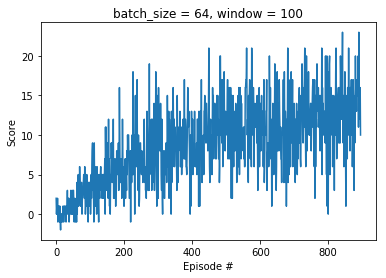

In [61]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('batch_size = 64, window = 100')
plt.show()

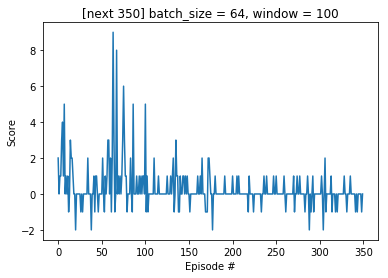

In [27]:
# scores = dqn(agent, n_episodes=50, feedback_every_secs=15, keep_last_scores=10)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('[next 350] batch_size = 64, window = 100')
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```